<a href="https://colab.research.google.com/github/chwon9-jpg/Diffusion_models/blob/main/Diffusion_model_2_alternate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepinv


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import time
import math

# ----------------------------
# Sinusoidal Positional Embedding used in Transformers (used for timestep embedding)
# ----------------------------
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None].float() * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


# ----------------------------
# Self-Attention Block
# ----------------------------
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.proj_query = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.proj_key = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.proj_value = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        # 1x1 convolutional layers act as linear transformations

    def forward(self, x):
        B, C, H, W = x.size()  # Batch_size, Channels, Height, Width

        query = self.proj_query(x).view(B, -1, H * W).permute(0, 2, 1)  # B, HW, C/8
        key = self.proj_key(x).view(B, -1, H * W)                      # B, C/8, HW

        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)

        value = self.proj_value(x).view(B, -1, H * W)                   # B, C, HW

        out = torch.bmm(value, attention.permute(0, 2, 1)) # B, C, HW
        out = out.view(B, C, H, W)

        out = self.gamma * out + x
        return out


# ----------------------------
# Simple UNet for MNIST Diffusion
# ----------------------------
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dim=32):
        super().__init__()

        # Encoder
        self.enc1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)

        self.enc2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1)

        self.enc3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, padding=1)

        self.enc4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 3, padding=1)


        # Attention after deepest encoder
        self.attn1 = SelfAttention(hidden_dim * 8)

        # Bottleneck
        self.bottleneck = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 3, padding=1)

        # Attention after bottleneck
        self.attn2 = SelfAttention(hidden_dim * 8)


        # Decoder
        self.dec4 = nn.Conv2d(hidden_dim * 8 + hidden_dim * 4, hidden_dim * 4, 3, padding=1)

        self.dec3 = nn.Conv2d(hidden_dim * 4 + hidden_dim * 2, hidden_dim * 2, 3, padding=1)

        self.dec2 = nn.Conv2d(hidden_dim * 2 + hidden_dim, hidden_dim, 3, padding=1)

        self.attn3 = SelfAttention(hidden_dim)

        self.dec1 = nn.Conv2d(hidden_dim + in_channels, out_channels, 3, padding=1)


        # Timestep embedding: Using Sinusoidal Positional Embedding + MLP
        time_embedding_dim = hidden_dim * 4 # Intermediate dim for sinusoidal embedding
        self.sinusoidal_embed = SinusoidalPositionalEmbedding(dim=time_embedding_dim)

        self.time_mlp_bottleneck = nn.Sequential(
            nn.Linear(time_embedding_dim, hidden_dim * 8), # Project to final bottleneck dim
            nn.SiLU(),
            nn.Linear(hidden_dim * 8, hidden_dim * 8)
        )

    def forward(self, x, t, type_t="timestep"):
        # Process timestep with positional embedding and MLP
        sinusoidal_emb = self.sinusoidal_embed(t)

        t_emb_bottleneck = self.time_mlp_bottleneck(sinusoidal_emb)
        t_emb_bottleneck = t_emb_bottleneck.unsqueeze(-1).unsqueeze(-1)  # [B, hidden_dim * 8, 1, 1]

        # Encoder (Downsampling)
        e1 = F.silu(self.enc1(x))
        p1 = F.max_pool2d(e1, 2)
        e2 = F.silu(self.enc2(p1))
        p2 = F.max_pool2d(e2, 2)
        e3 = F.silu(self.enc3(p2))
        p3 = F.max_pool2d(e3, 2)
        e4 = F.silu(self.enc4(p3))

        # Attention 1
        e4_attn = self.attn1(e4)

        # Bottleneck + timestep (MidBlock)
        b = F.silu(self.bottleneck(e4_attn) + t_emb_bottleneck)       # Conv -> Add T_emb -> SiLU
        # 4 x 4 spatial dimension

        # Attention 2
        b_attn = self.attn2(b)

        # Decoder (Upsampling)
        u4 = F.interpolate(b_attn, scale_factor=2, mode="nearest") # Spatial dimensions are upscaled by a factor of 2
        d4 = F.silu(self.dec4(torch.cat([u4, e3], dim=1))) # Skip-connection -> Conv -> SiLU

        u3 = F.interpolate(d4, scale_factor=2, mode="nearest")
        d3 = F.silu(self.dec3(torch.cat([u3, e2], dim=1))) # Skip-connection -> Conv -> SiLU

        u2 = F.interpolate(d3, scale_factor=2, mode="nearest")
        d2 = F.silu(self.dec2(torch.cat([u2, e1], dim=1))) # Skip-connection -> Conv -> SiLU

        d2_attn = self.attn3(d2)

        # Final output (no activation or normalization after the last layer)
        out = self.dec1(torch.cat([d2_attn, x], dim=1))


        return out

In [ ]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        # patience: Number of epochs to wait before stopping if no improvement.
        self.delta = delta
        # delta: Minimum change in the monitored quantity to qualify as an improvement.
        self.best_score = None # Track the best validation score
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None # Track the best model state

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [ ]:
import torchvision.transforms as transforms, torchvision, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")


# Hyperparameters
batch_size = 128
image_size = 32
lr = 1e-3
epochs = 50
timesteps = 500
beta_start = 1e-4
beta_end = 0.02

# Data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # Normalize to [-1, 1]
])

print("Loading MNIST dataset...")
full_trainset = torchvision.datasets.MNIST(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(full_trainset)) # 80% for training
val_size = len(full_trainset) - train_size  # Remaining for validation
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size, shuffle=False) # Use a separate dataloader for validation dataset

print(f"Dataset loaded. Training batches: {len(trainloader)}, Validation batches: {len(valloader)}\n")

# Model, optimizer, loss
model = SimpleUNet(in_channels=1, out_channels=1, hidden_dim=32).to(device)
initial_model_state = {k: v.clone() for k, v in model.state_dict().items()} # Save initial weights
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()
early_stopping = EarlyStopping(patience=10, delta=0.001)

# Precompute noise schedule
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)


# Print model size
num_params = sum(p.numel() for p in model.parameters())
print(f"Model: SimpleUNet | Parameters: {num_params:,}\n")

Using device: cuda

Loading MNIST dataset...
Dataset loaded. Training batches: 375, Validation batches: 94

Model: SimpleUNet | Parameters: 1,823,669



In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
print("Starting training...\n")
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    total_train_loss = 0.0

    for data, _ in trainloader:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        # Add noise
        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad() # Avoid Gradient Accumulation
        predicted_noise = model(noised_imgs, t) # Predict noise using U-net Model as mentioned before
        loss = mse(predicted_noise, noise)
        # Backprop + Update model params
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(trainloader)
    # average loss that the model incurred on each batch

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations
        for data, _ in valloader:
            imgs = data.to(device)
            noise = torch.randn_like(imgs)
            t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

            noised_imgs = (
                sqrt_alphas_cumprod[t, None, None, None] * imgs
                + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
            )
            predicted_noise = model(noised_imgs, t)
            val_loss = mse(predicted_noise, noise)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(valloader)

    epoch_time = time.time() - epoch_start_time
    total_elapsed = time.time() - total_start_time

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Avg Train Loss: {avg_train_loss:.6f} | "
          f"Avg Val Loss: {avg_val_loss:.6f} | "
          f"Epoch Time: {epoch_time:.2f}s | "
          f"Total Time: {total_elapsed:.2f}s")

    early_stopping(avg_val_loss, model) # Pass the validation loss
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break


early_stopping.load_best_model(model) # Load the best model weights found during training
final_model_state = model.state_dict() # Save final weights

# ----------------------------
# Save Model
# ----------------------------

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/simple_diffusion_model.pth")
print("\nTraining finished!")
print("Model saved to models/simple_diffusion_model.pth")

Starting training...

Epoch 1/50 | Avg Train Loss: 0.153812 | Avg Val Loss: 0.070515 | Epoch Time: 17.06s | Total Time: 17.06s
Epoch 2/50 | Avg Train Loss: 0.061514 | Avg Val Loss: 0.057363 | Epoch Time: 17.03s | Total Time: 34.09s
Epoch 3/50 | Avg Train Loss: 0.047735 | Avg Val Loss: 0.043535 | Epoch Time: 17.42s | Total Time: 51.51s
Epoch 4/50 | Avg Train Loss: 0.043008 | Avg Val Loss: 0.043779 | Epoch Time: 17.59s | Total Time: 69.11s
Epoch 5/50 | Avg Train Loss: 0.041022 | Avg Val Loss: 0.037429 | Epoch Time: 17.56s | Total Time: 86.67s
Epoch 6/50 | Avg Train Loss: 0.037140 | Avg Val Loss: 0.038330 | Epoch Time: 17.60s | Total Time: 104.26s
Epoch 7/50 | Avg Train Loss: 0.036128 | Avg Val Loss: 0.038707 | Epoch Time: 17.25s | Total Time: 121.51s
Epoch 8/50 | Avg Train Loss: 0.034717 | Avg Val Loss: 0.033359 | Epoch Time: 17.26s | Total Time: 138.77s
Epoch 9/50 | Avg Train Loss: 0.034139 | Avg Val Loss: 0.037489 | Epoch Time: 17.22s | Total Time: 155.99s
Epoch 10/50 | Avg Train Loss:

In [ ]:
print("\n--- Weight Comparison (Mean and Standard Deviation) ---")

# Choose a few representative layers to compare
layers_to_compare = [
    'enc1.weight',
    'dec1.weight',
    'bottleneck.weight',
    'time_mlp_bottleneck.0.weight'
]

for layer_name in layers_to_compare:
    print(f"\nLayer: {layer_name}")

    # Initial weights
    initial_weights = initial_model_state[layer_name].cpu().numpy()
    print(f"  Initial - Mean: {initial_weights.mean():.6f}, Std: {initial_weights.std():.6f}")

    # Final weights
    final_weights = final_model_state[layer_name].cpu().numpy()
    print(f"  Final   - Mean: {final_weights.mean():.6f}, Std: {final_weights.std():.6f}")


--- Weight Comparison (Mean and Standard Deviation) ---

Layer: enc1.weight
  Initial - Mean: 0.002552, Std: 0.184963
  Final   - Mean: -0.008917, Std: 0.239356

Layer: dec1.weight
  Initial - Mean: -0.002084, Std: 0.033908
  Final   - Mean: -0.000107, Std: 0.081703

Layer: bottleneck.weight
  Initial - Mean: -0.000008, Std: 0.012032
  Final   - Mean: 0.000798, Std: 0.072557

Layer: time_mlp_bottleneck.0.weight
  Initial - Mean: 0.000126, Std: 0.050962
  Final   - Mean: -0.008615, Std: 0.063108


In summary, for all selected layers, the standard deviation of the weights increased from their initial state to the final state. This indicates that the model's weights have moved away from their initial random values and have adapted during training to learn meaningful features and patterns necessary for the diffusion process. The means generally remain close to zero, which is often desirable for stable training.

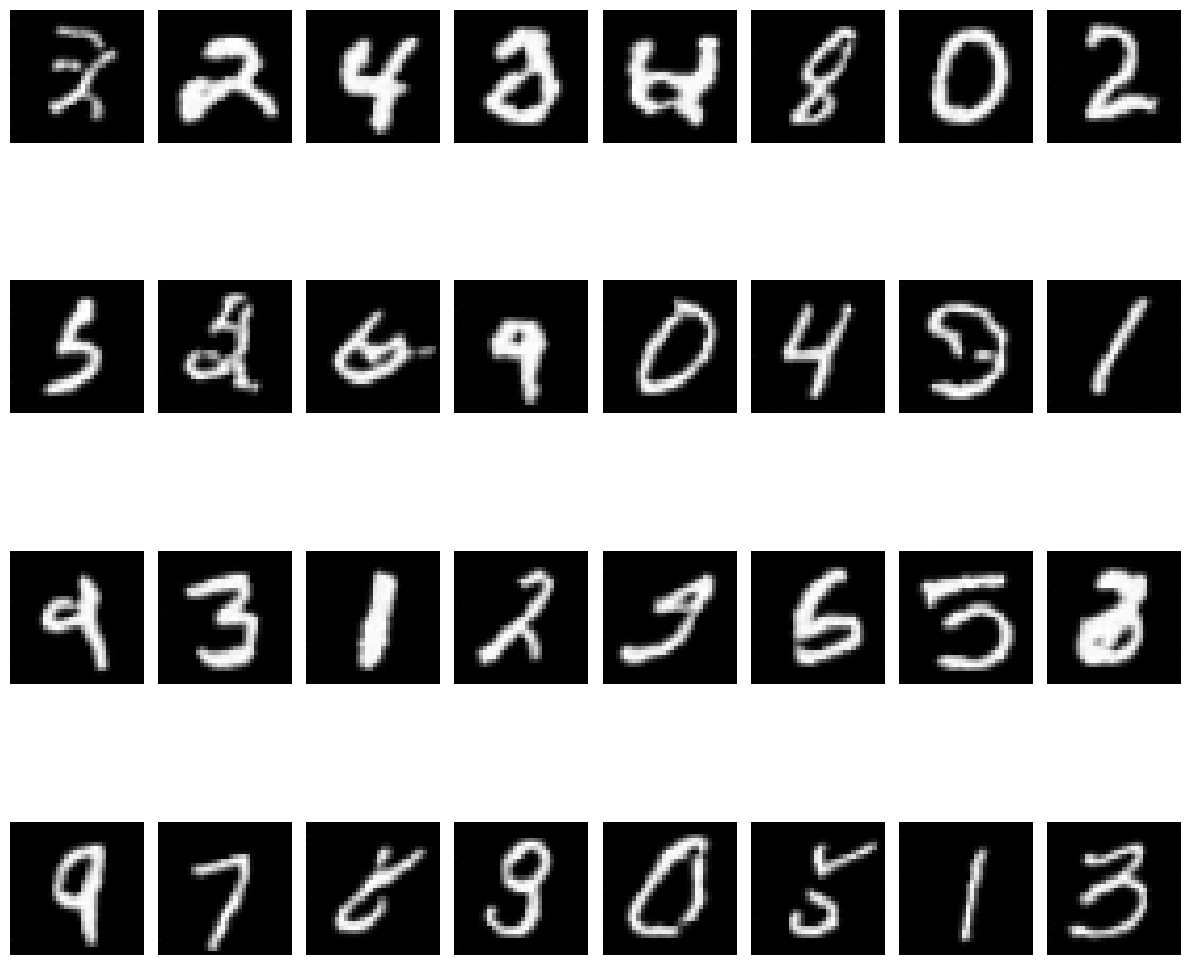

Generated 32 new MNIST-like digits!


In [ ]:
# ----------------------------
# Alternate method of generation according to DDPM paper
# ----------------------------

model.eval()  # Set to evaluation mode
num_samples = 32
img_size = 32

# Start with pure noise
x_t = torch.randn(num_samples, 1, img_size, img_size, device=device)

with torch.no_grad():
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict noise ε_θ(x_t, t)
        predicted_noise = model(x_t, t_batch)

        # Compute mean and variance for reverse step
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        alpha_bar_t_prev = alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0, device=device)
        beta_t = betas[t]

        # Denoise: x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1-alpha_bar_t) * predicted_noise) + sigma_t * z
        x_0_pred = (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]
        x_0_pred = torch.clamp(x_0_pred, -1, 1)  # Clip to [-1,1] for stability

        mean = x_t - ((beta_t * predicted_noise) / (sqrt_one_minus_alphas_cumprod[t]))
        mean = mean / torch.sqrt(alpha_t)

        if t == 0:
            # final step: don't add noise, just use the predicted x_0
            x_t = x_0_pred
        else:
            variance = (1 - alpha_bar_t_prev) / (1 - alpha_bar_t)
            variance = variance * beta_t  # still unused, but kept to match your original
            sigma_t = variance ** 0.5
            z = torch.randn_like(x_t)  # same shape & device as x_t
            x_t = mean + sigma_t * z   # only a single tensor, no tuple


# Post-process: convert to [0,1] and detach
generated_images = (x_t.clamp(-1, 1) + 1) / 2.0  # From [-1,1] to [0,1]

# Plot generated images
import matplotlib.pyplot as plt

# fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig, axes = plt.subplots(4, 8, figsize=(12, 12))  # 4 rows, 8 columns
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Generated 32 new MNIST-like digits!")

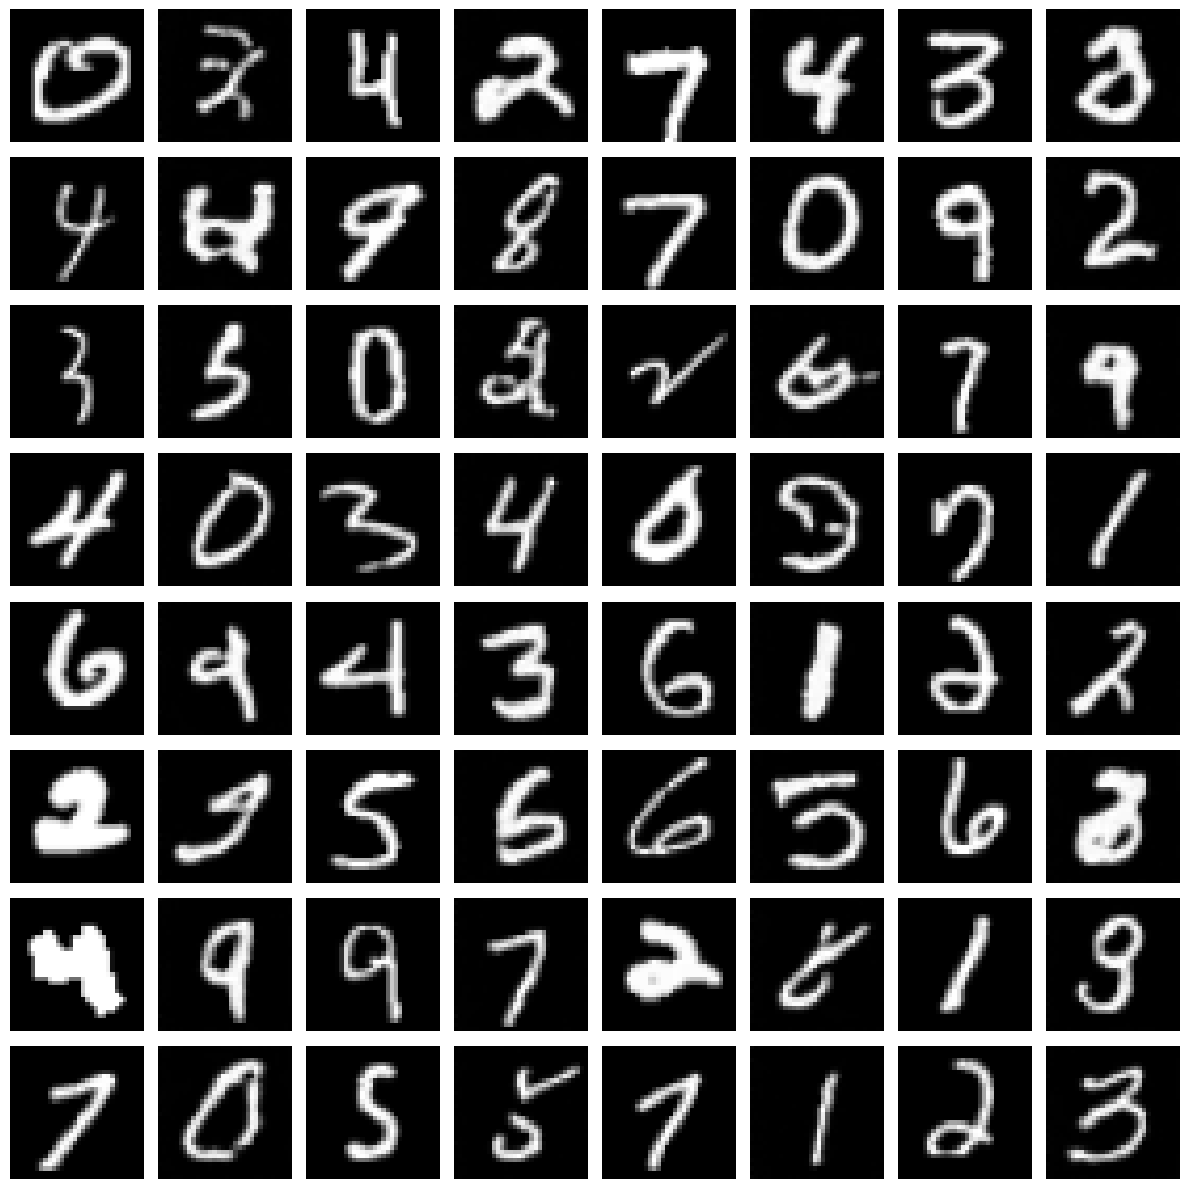

In [ ]:
# Show real MNIST for reference
real_batch = next(iter(trainloader))[0][:32].cpu()
real_batch = (real_batch + 1) / 2.0  # Only if you used Normalize((0.5,), (0.5,))

# Plot real vs generated side-by-side
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(32):
    # Real
    axes[i*2].imshow(real_batch[i].squeeze(), cmap='gray')
    axes[i*2].axis('off')
    # Generated
    axes[i*2 + 1].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[i*2 + 1].axis('off')

plt.tight_layout()
plt.show()